<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101078
Name = 'Tina'
Last_Name = 'Halimi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [2]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Importing Libraries

In [3]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [4]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [5]:
## FILL HERE

image_shape = train_set[0][0].shape
print(f"Dimentian: {image_shape}")
input_dim = image_shape[1] * image_shape[2]
print(f"Number of Pixels: {input_dim} pixels")
num_classes = len(train_set.classes)
print(f"Number of classes: {num_classes}")


Dimentian: torch.Size([1, 28, 28])
Number of Pixels: 784 pixels
Number of classes: 10


In [6]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

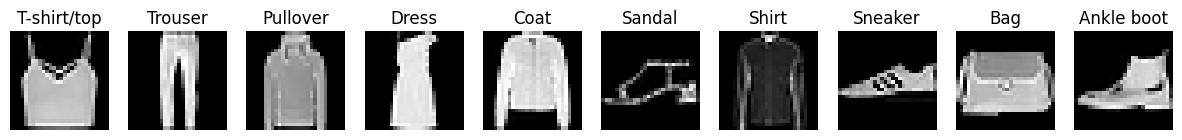

In [7]:
import random

classes = train_set.classes

fig, axes = plt.subplots(1, 10, figsize=(15, 3))

class_indices = {i: [] for i in range(10)}

for idx, (image, label) in enumerate(train_set):
    class_indices[label].append(idx)

# Display one random image from each class
for class_idx, img_indices in class_indices.items():
    img_idx = random.choice(img_indices)
    image, label = train_set[img_idx]
    axes[class_idx].imshow(image.squeeze(), cmap='gray')
    axes[class_idx].set_title(classes[label])
    axes[class_idx].axis('off')

plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [8]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [9]:

layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [10]:
def affine_forward(x, w, b):
    return torch.matmul(x,w) + b


def relu(x):
    # x.clamp(min=0)
    return torch.max(x,torch.zeros(x.shape,device=x.device))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [11]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    x_temp = x
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']

        x_temp = affine_forward(x_temp, w, b)
        
        if i < num_layers:
            x_temp = relu(x_temp)
    
    output = x_temp
    return output

Implementing cross entropy loss:

In [12]:
def cross_entropy_loss(scores, y):
    n = len(y)

    exp_scores = torch.exp(scores - torch.max(scores, dim=1, keepdim=True).values)
    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    # print(len(probs))
    correct_logprobs = -torch.log(probs[torch.arange(n), y])
    # loss = torch.sum(correct_logprobs) / n
    loss = correct_logprobs.mean()

    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [13]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''

    for param_name, param in parameters.items():
        param.data -= learning_rate * param.grad
        param.grad.zero_()

Training functions:

In [14]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    acc = np.mean(y_pred == y_true)
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    # print(N_train)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        p = model(x, parameters)

        loss = cross_entropy_loss(p , y)
        
        loss.backward()

        sgd_optimizer(parameters, learning_rate)

        train_loss += loss.item()

        print(f"Train: Epoch [{epoch}], Batch [{i+1}/{len(train_loader)}], Loss: {loss}")
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    train_loss /= len(Y_pred)
    # print('epoch loss')
    # print(train_loss)
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    # print(N)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        print(f"Validation: Epoch [{epoch}], Batch [{i+1}/{len(train_loader)}], Loss: {loss}")

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= len(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')
    # print('epoch loss valid')
    # print(total_loss)

    return total_loss, acc

In [15]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [16]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):

        train_loss, train_acc = train(train_loader, learning_rate, epoch + 1)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        test_loss, test_acc = validate(test_loader, epoch + 1, set_name='test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    plt.show()

In [17]:
print(len(train_losses))
print(len(test_losses))

0
0


Train: Epoch [1], Batch [1/938], Loss: 2.3027215003967285
Train: Epoch [1], Batch [2/938], Loss: 2.30234694480896
Train: Epoch [1], Batch [3/938], Loss: 2.3020036220550537
Train: Epoch [1], Batch [4/938], Loss: 2.3022048473358154
Train: Epoch [1], Batch [5/938], Loss: 2.3019611835479736
Train: Epoch [1], Batch [6/938], Loss: 2.301673412322998
Train: Epoch [1], Batch [7/938], Loss: 2.301635503768921
Train: Epoch [1], Batch [8/938], Loss: 2.3019447326660156
Train: Epoch [1], Batch [9/938], Loss: 2.3024179935455322
Train: Epoch [1], Batch [10/938], Loss: 2.3021247386932373
Train: Epoch [1], Batch [11/938], Loss: 2.3019871711730957
Train: Epoch [1], Batch [12/938], Loss: 2.301964282989502
Train: Epoch [1], Batch [13/938], Loss: 2.301469326019287
Train: Epoch [1], Batch [14/938], Loss: 2.302267551422119
Train: Epoch [1], Batch [15/938], Loss: 2.3021249771118164
Train: Epoch [1], Batch [16/938], Loss: 2.3024168014526367
Train: Epoch [1], Batch [17/938], Loss: 2.302306652069092
Train: Epoch [

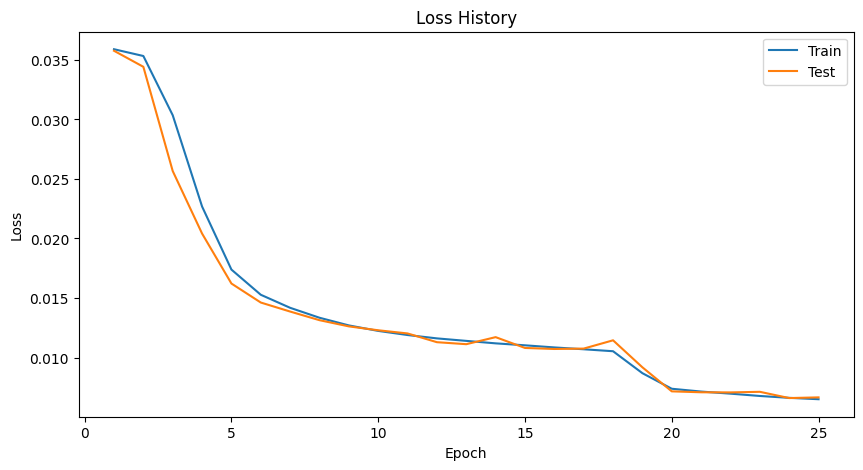

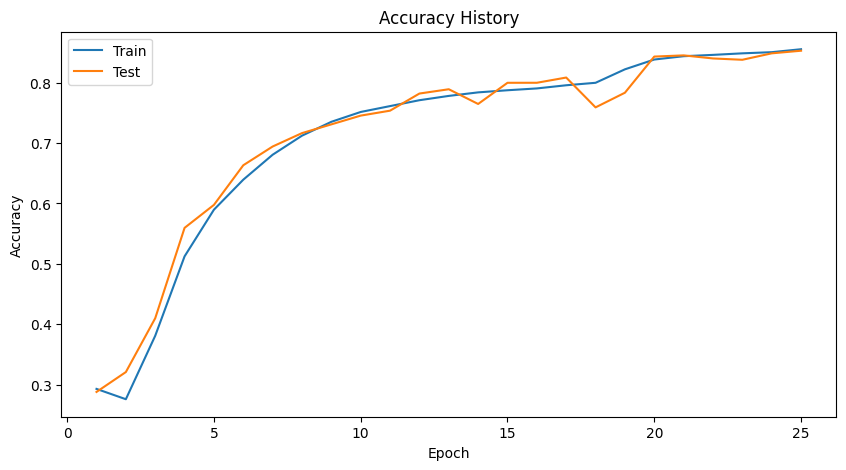

In [18]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [19]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8530166666666666


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

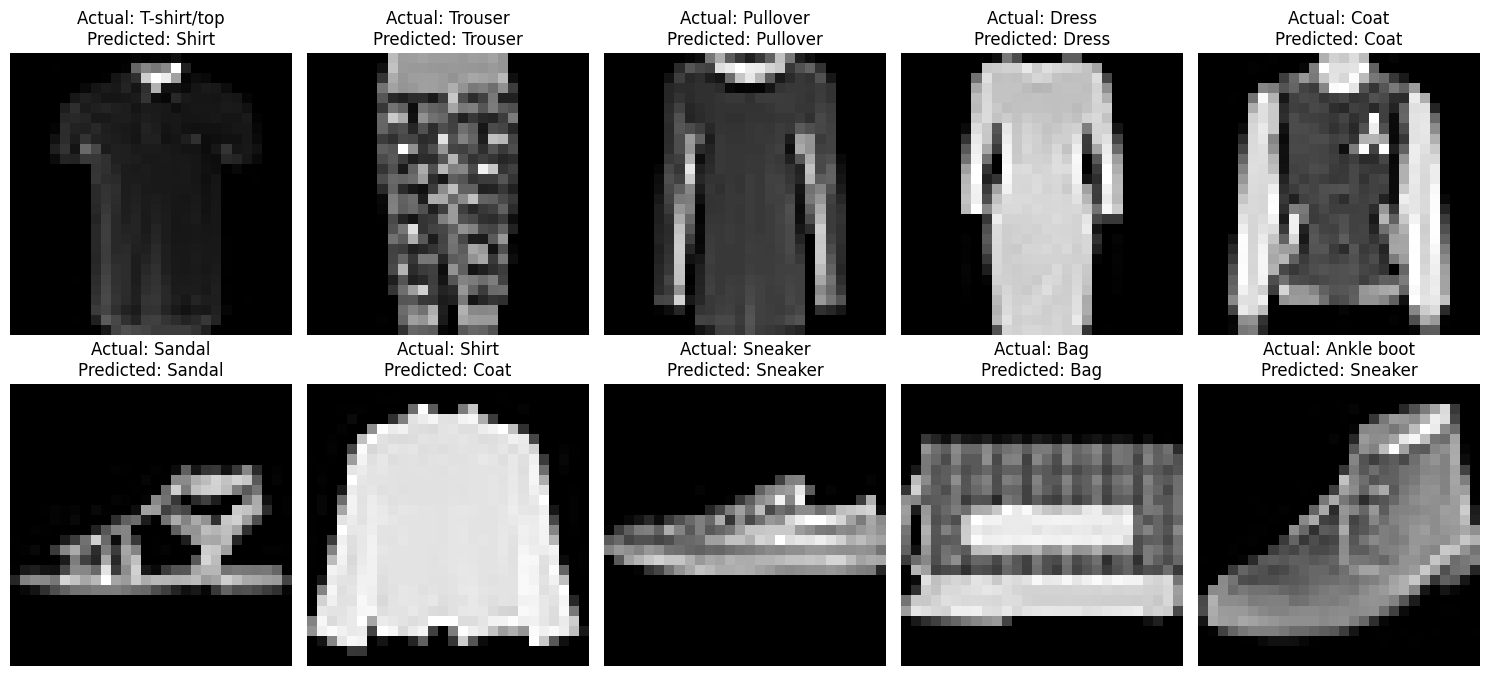

In [20]:
import matplotlib.pyplot as plt

def visualize_labels_predictions(data_loader):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    class_images = {class_name: None for class_name in class_names}
    
    # Iterate over the dataset
    for images, labels in data_loader:
        # Predict labels using the trained model
        outputs = model(images, parameters)
        _, predicted = torch.max(outputs, 1)
        
        # Iterate over the batch
        for image, label, prediction in zip(images, labels, predicted):
            class_name = class_names[label]
            # If no image is stored for this class yet, store the current image
            if class_images[class_name] is None:
                class_images[class_name] = (image, label, prediction)
                break
    
    # Visualize one image from each class along with actual and predicted labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    for i, (class_name, (image, label, prediction)) in enumerate(class_images.items()):
        ax = axes[i // 5, i % 5]
        ax.imshow(image.permute(1, 2, 0), cmap='gray')
        ax.set_title(f'Actual: {class_name}\nPredicted: {class_names[prediction]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_labels_predictions(test_loader)
